### Setup

In [1]:
import gc
import pickle

from feature_engine.creation import CyclicalFeatures
from feature_engine.encoding import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor

In [2]:
# plot style
plt.style.use(['science','no-latex'])

# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['savefig.format'] = 'eps'
plt.rcParams['figure.figsize'] = (6, 3)

# display all rows and columns when printing in the notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data

### Load data

In [3]:
# dtypes = {
#     'DayOfWeek':                       int,
#     'FlightDate':                      'string',
#     'IATA_CODE_Reporting_Airline':     'string',
#     'Tail_Number':                     'string',
#     'Flight_Number_Reporting_Airline': int,
#     'OriginAirportID':                 int,
#     'Origin':                          'string',
#     'OriginState':                     'string',
#     'DestAirportID':                   int,
#     'Dest':                            'string',
#     'DestState':                       'string',
#     'CRSDepTime':                      int,
#     'DepTime':                         int,
#     'DepDelayMinutes':                 int,
#     'CRSArrTime':                      int,
#     'ArrTime':                         int,
#     'ArrDelayMinutes':                 int,
#     'Cancelled':                       int,
#     'CancellationCode':                'string',
#     'Diverted':                        int,
#     'CRSElapsedTime':                  int,
#     'ActualElapsedTime':               int,
#     'AirTime':                         int,
#     'CarrierDelay':                    int,
#     'WeatherDelay':                    int,
#     'NASDelay':                        int,
#     'SecurityDelay':                   int,
#     'LateAircraftDelay':               int,
#     'CRSDepHour':                      int,
#     'OriginTz':                        'string',
#     'DestTz':                          'string',
#     'CRSArrDateTime':                  'string',
#     'CRSArrDate':                      'string',
#     'CRSArrHour':                      int,
#     'o_temperature_2m':                float,
#     'o_relative_humidity_2m':          float,
#     'o_dew_point_2m':                  float,
#     'o_apparent_temperature':          float,
#     'o_precipitation':                 float,
#     'o_rain':                          float,
#     'o_snowfall':                      float,
#     'o_snow_depth':                    float,
#     'o_weather_code':                  float,
#     'o_surface_pressure':              float,
#     'o_cloud_cover':                   float,
#     'o_cloud_cover_low':               float,
#     'o_cloud_cover_mid':               float,
#     'o_cloud_cover_high':              float,
#     'o_wind_speed_10m':                float,
#     'o_wind_speed_100m':               float,
#     'o_wind_gusts_10m':                float,
#     'o_shortwave_radiation':           float,
#     'o_direct_radiation':              float,
#     'o_diffuse_radiation':             float,
#     'o_direct_normal_irradiance':      float,
#     'o_terrestrial_radiation':         float,
#     'o_airport':                       'string',
#     'o_day':                           'string',
#     'o_hour':                          int,
#     'd_temperature_2m':                float,
#     'd_relative_humidity_2m':          float,
#     'd_dew_point_2m':                  float,
#     'd_apparent_temperature':          float,
#     'd_precipitation':                 float,
#     'd_rain':                          float,
#     'd_snowfall':                      float,
#     'd_snow_depth':                    float,
#     'd_weather_code':                  float,
#     'd_surface_pressure':              float,
#     'd_cloud_cover':                   float,
#     'd_cloud_cover_low':               float,
#     'd_cloud_cover_mid':               float,
#     'd_cloud_cover_high':              float,
#     'd_wind_speed_10m':                float,
#     'd_wind_speed_100m':               float,
#     'd_wind_gusts_10m':                float,
#     'd_shortwave_radiation':           float,
#     'd_direct_radiation':              float,
#     'd_diffuse_radiation':             float,
#     'd_direct_normal_irradiance':      float,
#     'd_terrestrial_radiation':         float,
#     'd_airport':                       'string',
#     'd_day':                           'string',
#     'd_hour':                          int
# }

def load_data():
    files = [
        'data/weather-joined/full-w-2017.csv',
        'data/weather-joined/full-w-2018.csv',
        'data/weather-joined/full-w-2019.csv',
    ]

    dfs = [pd.read_csv(f, low_memory=False) for f in files]
    return pd.concat(dfs, ignore_index=True)

In [4]:
df = load_data()

In [33]:
sept_df = pd.read_csv("predict/curr-2023-08.csv", low_memory=False)

In [34]:
sept_df['target'] = sept_df['NASDelay'] + sept_df['WeatherDelay']

In [45]:
sept_df[sept_df['target'] > 30][['Origin', 'Dest', 'FlightDate','target']].head(20)

,Origin,Dest,FlightDate,target
45,CLT,JFK,2023-08-17,78.0
55,CLT,JFK,2023-08-29,672.0
80,JFK,CLT,2023-08-27,32.0
227,LGA,DAY,2023-08-04,45.0
229,LGA,DAY,2023-08-07,58.0
319,BGR,JFK,2023-08-07,789.0
322,BGR,JFK,2023-08-10,86.0
324,BGR,JFK,2023-08-12,105.0
329,BGR,JFK,2023-08-17,123.0
330,BGR,JFK,2023-08-18,37.0


In [6]:
df.shape[0]

19127490

In [6]:
df.head()

,DayOfWeek,FlightDate,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,Origin,OriginState,DestAirportID,Dest,DestState,CRSDepTime,DepTime,DepDelayMinutes,CRSArrTime,ArrTime,ArrDelayMinutes,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,CRSDepHour,OriginTz,DestTz,CRSArrDateTime,CRSArrDate,CRSArrHour,o_temperature_2m,o_relative_humidity_2m,o_dew_point_2m,o_apparent_temperature,o_precipitation,o_rain,o_snowfall,o_snow_depth,o_weather_code,o_surface_pressure,o_cloud_cover,o_cloud_cover_low,o_cloud_cover_mid,o_cloud_cover_high,o_wind_speed_10m,o_wind_speed_100m,o_wind_gusts_10m,o_shortwave_radiation,o_direct_radiation,o_diffuse_radiation,o_direct_normal_irradiance,o_terrestrial_radiation,o_airport,o_day,o_hour,d_temperature_2m,d_relative_humidity_2m,d_dew_point_2m,d_apparent_temperature,d_precipitation,d_rain,d_snowfall,d_snow_depth,d_weather_code,d_surface_pressure,d_cloud_cover,d_cloud_cover_low,d_cloud_cover_mid,d_cloud_cover_high,d_wind_speed_10m,d_wind_speed_100m,d_wind_gusts_10m,d_shortwave_radiation,d_direct_radiation,d_diffuse_radiation,d_direct_normal_irradiance,d_terrestrial_radiation,d_airport,d_day,d_hour
0,7,2017-01-01,AA,N787AA,1,12478,JFK,NY,12892,LAX,CA,800,831.0,31.0,1142,1209.0,27.0,0,NaN,0,402.0,398.0,347.0,27.0,0.0,0.0,0.0,0.0,7,America/New_York,America/Los_Angeles,2017-01-01 12:09:00-08:00,2017-01-01,11,42.9953,55.499237,28.145300,32.976753,0.011811,0.011811,0.0,0.0,51.0,1013.05206,52.800000,0.0,80.0,16.0,13.350974,22.423624,25.278101,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-01,7.0,43.743202,81.152390,38.3432,37.638832,0.000000,0.000000,0.0,0.0,0.0,1006.27985,0.000000,0.0,0.0,0.0,7.993950,12.424918,11.632400,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-01,11.0
1,1,2017-01-02,AA,N788AA,1,12478,JFK,NY,12892,LAX,CA,800,757.0,0.0,1142,1154.0,12.0,0,NaN,0,402.0,417.0,362.0,NaN,NaN,NaN,NaN,NaN,7,America/New_York,America/Los_Angeles,2017-01-02 11:38:00-08:00,2017-01-02,11,32.1953,78.183426,26.165300,25.610653,0.000000,0.000000,0.0,0.0,1.0,1031.14220,29.400002,0.0,0.0,98.0,4.611693,12.112896,8.053200,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-02,7.0,51.483200,82.565260,46.3532,48.706870,0.000000,0.000000,0.0,0.0,3.0,1010.93726,100.000000,100.0,63.0,90.0,4.320365,6.521919,6.934699,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-02,11.0
2,2,2017-01-03,AA,N783AA,1,12478,JFK,NY,12892,LAX,CA,800,754.0,0.0,1142,1118.0,0.0,0,NaN,0,402.0,384.0,354.0,NaN,NaN,NaN,NaN,NaN,7,America/New_York,America/Los_Angeles,2017-01-03 11:38:00-08:00,2017-01-03,11,41.6453,92.292366,39.575300,34.548943,0.003937,0.003937,0.0,0.0,51.0,1022.94904,100.000000,100.0,96.0,100.0,10.915552,18.522575,19.461899,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-03,7.0,48.963200,91.282074,46.5332,45.944515,0.000000,0.000000,0.0,0.0,1.0,1016.18290,42.300003,9.0,7.0,100.0,5.002084,8.204028,7.605800,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-03,11.0
3,3,2017-01-04,AA,N799AA,1,12478,JFK,NY,12892,LAX,CA,800,757.0,0.0,1142,1132.0,0.0,0,NaN,0,402.0,395.0,360.0,NaN,NaN,NaN,NaN,NaN,7,America/New_York,America/Los_Angeles,2017-01-04 11:38:00-08:00,2017-01-04,11,40.2953,96.561200,39.395300,34.806420,0.000000,0.000000,0.0,0.0,3.0,997.55470,90.000000,100.0,0.0,0.0,7.024322,11.106429,12.527200,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-04,7.0,48.963200,86.143740,45.0032,45.648950,0.000000,0.000000,0.0,0.0,0.0,1015.48670,19.200000,20.0,2.0,0.0,4.803042,1.432379,6.039900,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-04,11.0
4,4,2017-01-05,AA,N788AA,1,12478,JFK,NY,12892,LAX,CA,800,753.0,0.0,1142,1141.0,0.0,0,NaN,0,402.0,408.0,387.0,NaN,NaN,NaN,NaN,NaN,7,America/New_York,America/Los_Angeles,2017-01-05 11:38:00-08:00,2017-01-05,11,29.4053,47.067635,11.675299,17.958977,0.000000,0.000000,0.0,0.0,0.0,1009.74590,0.000000,0.0,0.0,0.0,12.821347,20.341946,25.501799,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-05,7.0,56.073200,91.537660,53.6432,54.387240,0.023622,0.023622,0.0,0.0,53.0,1011.38280,100.000000,100.0,91.0,0.0,6.673613,7.915314,12.303500,0.0,0.0,0.0,0.0,0

### Clean

In [7]:
def clean_data(df):
    # convert string timestamps to datetime objects
    datetime_cols = ['FlightDate', 'CRSArrDateTime', 'CRSArrDate', 'o_day', 'd_day']
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col])

    # drop rows that have cancelled or diverted flights
    df = df.drop(df[(df['Cancelled'] == 1) | (df['Diverted'] == 1)].index)

    # fill 0s for columns that make sense
    cols = ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "o_snow_depth", "d_snow_depth"]
    df[cols] = df[cols].fillna(value=0)

    # we won't use `CancellationCode`, so drop it
    df = df.drop('CancellationCode', axis=1)

    # drop rows that have `NaN`s for the other columns.
    df = df.dropna()
    
    return df

In [8]:
df = clean_data(df)
df.shape[0]

/tmp/ipykernel_357095/1114253781.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[col] = pd.to_datetime(df[col])


18770048

In [9]:
df.isnull().sum()

DayOfWeek                          0
FlightDate                         0
IATA_CODE_Reporting_Airline        0
Tail_Number                        0
Flight_Number_Reporting_Airline    0
OriginAirportID                    0
Origin                             0
OriginState                        0
DestAirportID                      0
Dest                               0
DestState                          0
CRSDepTime                         0
DepTime                            0
DepDelayMinutes                    0
CRSArrTime                         0
ArrTime                            0
ArrDelayMinutes                    0
Cancelled                          0
Diverted                           0
CRSElapsedTime                     0
ActualElapsedTime                  0
AirTime                            0
CarrierDelay                       0
WeatherDelay                       0
NASDelay                           0
SecurityDelay                      0
LateAircraftDelay                  0
C

In [10]:
df.head()

,DayOfWeek,FlightDate,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,Origin,OriginState,DestAirportID,Dest,DestState,CRSDepTime,DepTime,DepDelayMinutes,CRSArrTime,ArrTime,ArrDelayMinutes,Cancelled,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,CRSDepHour,OriginTz,DestTz,CRSArrDateTime,CRSArrDate,CRSArrHour,o_temperature_2m,o_relative_humidity_2m,o_dew_point_2m,o_apparent_temperature,o_precipitation,o_rain,o_snowfall,o_snow_depth,o_weather_code,o_surface_pressure,o_cloud_cover,o_cloud_cover_low,o_cloud_cover_mid,o_cloud_cover_high,o_wind_speed_10m,o_wind_speed_100m,o_wind_gusts_10m,o_shortwave_radiation,o_direct_radiation,o_diffuse_radiation,o_direct_normal_irradiance,o_terrestrial_radiation,o_airport,o_day,o_hour,d_temperature_2m,d_relative_humidity_2m,d_dew_point_2m,d_apparent_temperature,d_precipitation,d_rain,d_snowfall,d_snow_depth,d_weather_code,d_surface_pressure,d_cloud_cover,d_cloud_cover_low,d_cloud_cover_mid,d_cloud_cover_high,d_wind_speed_10m,d_wind_speed_100m,d_wind_gusts_10m,d_shortwave_radiation,d_direct_radiation,d_diffuse_radiation,d_direct_normal_irradiance,d_terrestrial_radiation,d_airport,d_day,d_hour
0,7,2017-01-01,AA,N787AA,1,12478,JFK,NY,12892,LAX,CA,800,831.0,31.0,1142,1209.0,27.0,0,0,402.0,398.0,347.0,27.0,0.0,0.0,0.0,0.0,7,America/New_York,America/Los_Angeles,2017-01-01 12:09:00-08:00,2017-01-01,11,42.9953,55.499237,28.145300,32.976753,0.011811,0.011811,0.0,0.0,51.0,1013.05206,52.800000,0.0,80.0,16.0,13.350974,22.423624,25.278101,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-01,7.0,43.743202,81.152390,38.3432,37.638832,0.000000,0.000000,0.0,0.0,0.0,1006.27985,0.000000,0.0,0.0,0.0,7.993950,12.424918,11.632400,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-01,11.0
1,1,2017-01-02,AA,N788AA,1,12478,JFK,NY,12892,LAX,CA,800,757.0,0.0,1142,1154.0,12.0,0,0,402.0,417.0,362.0,0.0,0.0,0.0,0.0,0.0,7,America/New_York,America/Los_Angeles,2017-01-02 11:38:00-08:00,2017-01-02,11,32.1953,78.183426,26.165300,25.610653,0.000000,0.000000,0.0,0.0,1.0,1031.14220,29.400002,0.0,0.0,98.0,4.611693,12.112896,8.053200,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-02,7.0,51.483200,82.565260,46.3532,48.706870,0.000000,0.000000,0.0,0.0,3.0,1010.93726,100.000000,100.0,63.0,90.0,4.320365,6.521919,6.934699,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-02,11.0
2,2,2017-01-03,AA,N783AA,1,12478,JFK,NY,12892,LAX,CA,800,754.0,0.0,1142,1118.0,0.0,0,0,402.0,384.0,354.0,0.0,0.0,0.0,0.0,0.0,7,America/New_York,America/Los_Angeles,2017-01-03 11:38:00-08:00,2017-01-03,11,41.6453,92.292366,39.575300,34.548943,0.003937,0.003937,0.0,0.0,51.0,1022.94904,100.000000,100.0,96.0,100.0,10.915552,18.522575,19.461899,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-03,7.0,48.963200,91.282074,46.5332,45.944515,0.000000,0.000000,0.0,0.0,1.0,1016.18290,42.300003,9.0,7.0,100.0,5.002084,8.204028,7.605800,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-03,11.0
3,3,2017-01-04,AA,N799AA,1,12478,JFK,NY,12892,LAX,CA,800,757.0,0.0,1142,1132.0,0.0,0,0,402.0,395.0,360.0,0.0,0.0,0.0,0.0,0.0,7,America/New_York,America/Los_Angeles,2017-01-04 11:38:00-08:00,2017-01-04,11,40.2953,96.561200,39.395300,34.806420,0.000000,0.000000,0.0,0.0,3.0,997.55470,90.000000,100.0,0.0,0.0,7.024322,11.106429,12.527200,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-04,7.0,48.963200,86.143740,45.0032,45.648950,0.000000,0.000000,0.0,0.0,0.0,1015.48670,19.200000,20.0,2.0,0.0,4.803042,1.432379,6.039900,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-04,11.0
4,4,2017-01-05,AA,N788AA,1,12478,JFK,NY,12892,LAX,CA,800,753.0,0.0,1142,1141.0,0.0,0,0,402.0,408.0,387.0,0.0,0.0,0.0,0.0,0.0,7,America/New_York,America/Los_Angeles,2017-01-05 11:38:00-08:00,2017-01-05,11,29.4053,47.067635,11.675299,17.958977,0.000000,0.000000,0.0,0.0,0.0,1009.74590,0.000000,0.0,0.0,0.0,12.821347,20.341946,25.501799,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-05,7.0,56.073200,91.537660,53.6432,54.387240,0.023622,0.023622,0.0,0.0,53.0,1011.38280,100.000000,100.0,91.0,0.0,6.673613,7.915314,12.303500,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-05,11.0


### Prepare data

In [9]:
# true/false field that indicates if it is a weekend
def is_weekend(df):
    df['weekend'] = df['DayOfWeek'] >= 6
    return df


# perform cyclical feature encoding to columns
def cyclical_encode(cols):
    cf = CyclicalFeatures(variables=cols, drop_original=False)

    def inner(df):    
        return cf.fit_transform(df)

    return inner


# extract month from the date
# assumption: df[col] is of type datetime
def get_month(col, pref):
    def inner(df):
        df[f"{pref}_month"] = df[col].dt.month
        return df

    return inner


# extract day of month from the date
# assumption: df[col] is of type datetime
def get_day_of_month(col, pref):
    def inner(df):
        df[f"{pref}_day_of_month"] = df[col].dt.day
        return df

    return inner


# perform one-hot encoding
def one_hot_encode(cols):
    ohe = OneHotEncoder(variables=cols, drop_last_binary=True, ignore_format=True)

    def inner(df):
        return ohe.fit_transform(df)

    return inner

def apply_funcs(df, funcs):
    for f in funcs:
        df = f(df)
    return df

### Merge other datasets

Add cluster labels to each of the origin and destination airports

In [10]:
def add_cluster_labels(df):
    cluster_labels = pd.read_csv('latitude_longitude_cluster.csv')
    clustered = pd.merge(df, cluster_labels.add_prefix('o_'), left_on=['Origin'], right_on=['o_IATA_CODE'], how='left')
    clustered = pd.merge(clustered, cluster_labels.add_prefix('d_'), left_on=['Dest'], right_on=['d_IATA_CODE'], how='left')
    return clustered

In [11]:
def add_weather_features(df):
    avg_daily_weather = pd.read_csv("data/weather-joined/average_daily_weather.csv")
    avg_daily_weather = avg_daily_weather.fillna(value=0)

    df = pd.merge(df, avg_daily_weather.add_prefix('o_'),
                  left_on=['Origin', 'o_month', 'o_day_of_month'],
                  right_on=['o_airport', 'o_month', 'o_day'],
                  how='left')
    df['o_temp_delta'] = df['o_temperature_2m'] - df['o_temperature_2m_mean']
    df['o_humidity_delta'] = df['o_relative_humidity_2m'] - df['o_relative_humidity_2m_mean']
    df['o_dew_point_delta'] = df['o_dew_point_2m'] - df['o_dew_point_2m_mean']
    df['o_precipitation_delta'] = df['o_precipitation'] - df['o_precipitation_sum']

    df = pd.merge(df, avg_daily_weather.add_prefix('d_'),
                  left_on=['Dest', 'd_month', 'd_day_of_month'],
                  right_on=['d_airport', 'd_month', 'd_day'],
                  how='left')
    df['d_temp_delta'] = df['d_temperature_2m'] - df['d_temperature_2m_mean']
    df['d_humidity_delta'] = df['d_relative_humidity_2m'] - df['d_relative_humidity_2m_mean']
    df['d_dew_point_delta'] = df['d_dew_point_2m'] - df['d_dew_point_2m_mean']
    df['d_precipitation_delta'] = df['d_precipitation'] - df['d_precipitation_sum']

    return df

In [12]:
# Balance the dataset by sampling equal number of non-delay records as delay records
def balance_dataset(df):
    delay_mask = (df['NASDelay'] > 0) | (df['WeatherDelay'] > 0)
    delay_df = df[delay_mask]
    non_delay_df = df[~delay_mask]

    # print(delay_df.shape)
    # print(non_delay_df.shape)

    num_delay_records = delay_df.shape[0]
    df = pd.concat([delay_df, non_delay_df.sample(num_delay_records, replace=False)])
    
    return df

In [13]:
def dim_reduction(df, num_components):
    num_components = min(num_components, *df.shape)
    pca = PCA(n_components=num_components)
    pca.fit(df)
    return pca.transform(df)

In [14]:
def tpr_fpr(Y_test, Y_pred):
    bool_pred = Y_pred >= 15
    bool_test = Y_test >= 15
    
    accuracy = np.sum(bool_pred == bool_test) / len(bool_pred)
    tn, fp, fn, tp = confusion_matrix(bool_test, bool_pred).ravel()

    print(tn, fp, fn, tp)

    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)

    return (accuracy, tpr, fpr)

def print_metrics(Y_test, Y_pred):
    rmse = mean_squared_error(Y_test, Y_pred, squared=False)
    mae = mean_absolute_error(Y_test, Y_pred)
    metrics = tpr_fpr(Y_test, Y_pred)
    
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("Accuracy, TPR, FPR:", metrics)

    return (rmse, mae, *metrics)

## Baseline models

### Baseline 0 - The Average returner

Let's build the absolute baseline possible - a model that returns the average weather-related delay of the entire training set, and see how it performs.

In [14]:
def baseline_avg_returner(X_train, X_test, Y_train):
    train_mean = Y_train.mean()
    Y_pred = np.repeat(train_mean, len(X_test))

    return Y_pred.clip(min=0, max=120)

### Baseline 1 - Simple linear regression

Now, let's build a simple linear regression that tries to predict the delay.

In [15]:
def baseline_linear_regression(X_train, X_test, Y_train):
    model = LinearRegression()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    return Y_pred.clip(min=0, max=120)

### Baseline 2 - Decision tree regression

In [16]:
def baseline_decision_tree_regression(X_train, X_test, Y_train):
    model = DecisionTreeRegressor()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    return Y_pred.clip(min=0, max=120)

### Run all the baseline models

In [17]:
def baseline(df, cols, points_to_plot = 100):
    sampled_df = balance_dataset(df)
    
    X = sampled_df[cols]
    Y = sampled_df['WeatherDelay'] + sampled_df['NASDelay']
    Y = Y.clip(upper=120)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
    
    # average model
    y_avg_pred = baseline_avg_returner(X_train, X_test, Y_train)
    print("avg model")
    print_metrics(Y_test, y_avg_pred)

    # linear regression model
    y_lin_pred = baseline_linear_regression(X_train, X_test, Y_train)
    print("linear regression")
    print_metrics(Y_test, y_lin_pred)

    # decision tree regression model
    y_dtr_pred = baseline_decision_tree_regression(X_train, X_test, Y_train)
    print("decision tree regression")
    print_metrics(Y_test, y_dtr_pred)

    # line plot
    plt.figure(1)
    plt.plot(range(points_to_plot), Y_test[:points_to_plot], label="actual")
    plt.plot(range(points_to_plot), y_avg_pred[:points_to_plot], label="average")
    plt.plot(range(points_to_plot), y_lin_pred[:points_to_plot], label="lin-reg")
    plt.plot(range(points_to_plot), y_dtr_pred[:points_to_plot], label="dec-tree-reg")

    plt.legend(frameon=True,
               framealpha=1,
               bbox_to_anchor=(0, 1.02, 1, 0.2),
               loc="lower left",
               mode="expand",
               borderaxespad=0,
               ncol=4)

    plt.ylabel("Weather delay in minutes")
    plt.xlabel("Data points")
    plt.savefig("baseline.eps", bbox_inches="tight")

    plt.show()

avg model
900303 0 438769 0
RMSE: 26.30656500582023
MAE: 17.8418985698695
Accuracy, TPR, FPR: (0.6723335265019357, 0.0, 0.0)
linear regression
439690 460613 205869 232900
RMSE: 26.281452511575058
MAE: 17.85324250566827
Accuracy, TPR, FPR: (0.502280683936338, 0.5308032244757492, 0.5116199768300228)
decision tree regression
615417 284886 268027 170742
RMSE: 35.781155117865
MAE: 21.37945917023133
Accuracy, TPR, FPR: (0.5870924042919275, 0.3891387039649565, 0.3164334673993089)


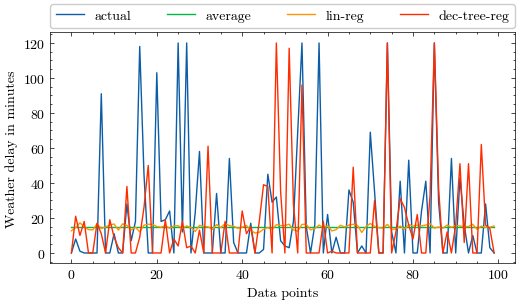

In [19]:
baseline(df, ['o_temperature_2m', 'd_temperature_2m'])

avg model
0 1043 0 648
RMSE: 30.56335152081668
MAE: 21.95708743858179
Accuracy, TPR, FPR: (0.38320520402128916, 1.0, 1.0)
linear regression
473 570 232 416
RMSE: 28.904083880355994
MAE: 20.819807797970913
Accuracy, TPR, FPR: (0.5257244234180958, 0.6419753086419753, 0.5465004793863855)
decision tree regression
733 310 268 380
RMSE: 34.231547633826395
MAE: 20.156416321703134
Accuracy, TPR, FPR: (0.6581904198698995, 0.5864197530864198, 0.2972195589645254)


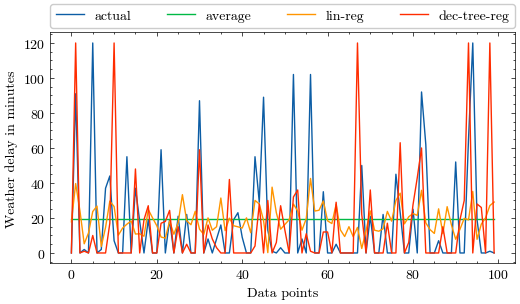

In [20]:
baseline(
    df[(df['Origin'] == 'JFK') & (df['FlightDate'].dt.month == 1)],
    ['o_temperature_2m', 'o_snowfall', 'd_temperature_2m', 'd_snowfall']
)

avg model
0 1027 0 664
RMSE: 29.84307658790643
MAE: 21.78112337488523
Accuracy, TPR, FPR: (0.39266706091070375, 1.0, 1.0)
linear regression
627 400 187 477
RMSE: 25.471023927831677
MAE: 18.107065219274865
Accuracy, TPR, FPR: (0.6528681253696038, 0.7183734939759037, 0.3894839337877313)
decision tree regression
754 273 229 435
RMSE: 32.03480698651878
MAE: 18.61679479597871
Accuracy, TPR, FPR: (0.7031342400946186, 0.6551204819277109, 0.26582278481012656)


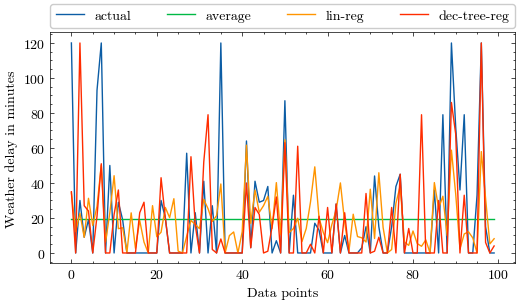

In [21]:
baseline(
    df[(df['Origin'] == 'JFK') & (df['FlightDate'].dt.month == 1)],
    [
        'CRSElapsedTime',
        'o_temperature_2m',
        'o_relative_humidity_2m',
        'o_dew_point_2m',
        'o_apparent_temperature',
        'o_precipitation',
        'o_rain',
        'o_snowfall',
        'o_snow_depth',
        'o_weather_code',
        'o_surface_pressure',
        'o_cloud_cover',
        'o_cloud_cover_low',
        'o_cloud_cover_mid',
        'o_cloud_cover_high',
        'o_wind_speed_10m',
        'o_wind_speed_100m',
        'o_wind_gusts_10m',
        'o_shortwave_radiation',
        'o_direct_radiation',
        'o_diffuse_radiation',
        'o_direct_normal_irradiance',
        'o_terrestrial_radiation',
        'd_temperature_2m',
        'd_relative_humidity_2m',
        'd_dew_point_2m',
        'd_apparent_temperature',
        'd_precipitation',
        'd_rain',
        'd_snowfall',
        'd_snow_depth',
        'd_weather_code',
        'd_surface_pressure',
        'd_cloud_cover',
        'd_cloud_cover_low',
        'd_cloud_cover_mid',
        'd_cloud_cover_high',
        'd_wind_speed_10m',
        'd_wind_speed_100m',
        'd_wind_gusts_10m',
        'd_shortwave_radiation',
        'd_direct_radiation',
        'd_diffuse_radiation',
        'd_direct_normal_irradiance',
        'd_terrestrial_radiation',
    ]
)

avg model
0 65251 0 35947
RMSE: 26.87884238116173
MAE: 18.646543979783573
Accuracy, TPR, FPR: (0.35521452993142155, 1.0, 1.0)
linear regression
38098 27153 12497 23450
RMSE: 25.39615772926806
MAE: 17.2740091137931
Accuracy, TPR, FPR: (0.6081938378228818, 0.6523492920132418, 0.41613155353940934)
decision tree regression
46070 19181 16547 19400
RMSE: 31.595568810794305
MAE: 18.527930393881302
Accuracy, TPR, FPR: (0.6469495444574004, 0.5396834228169249, 0.2939571807328623)


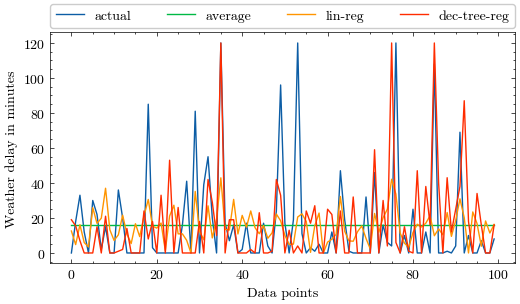

In [22]:
baseline(
    df[(df['Origin'] == 'JFK') | (df['Origin'] == 'BOS') | (df['Origin'] == 'LGA')],
    [
        'CRSElapsedTime',
        'o_temperature_2m',
        'o_relative_humidity_2m',
        'o_dew_point_2m',
        'o_apparent_temperature',
        'o_precipitation',
        'o_rain',
        'o_snowfall',
        'o_snow_depth',
        'o_weather_code',
        'o_surface_pressure',
        'o_cloud_cover',
        'o_cloud_cover_low',
        'o_cloud_cover_mid',
        'o_cloud_cover_high',
        'o_wind_speed_10m',
        'o_wind_speed_100m',
        'o_wind_gusts_10m',
        'o_shortwave_radiation',
        'o_direct_radiation',
        'o_diffuse_radiation',
        'o_direct_normal_irradiance',
        'o_terrestrial_radiation',
        'd_temperature_2m',
        'd_relative_humidity_2m',
        'd_dew_point_2m',
        'd_apparent_temperature',
        'd_precipitation',
        'd_rain',
        'd_snowfall',
        'd_snow_depth',
        'd_weather_code',
        'd_surface_pressure',
        'd_cloud_cover',
        'd_cloud_cover_low',
        'd_cloud_cover_mid',
        'd_cloud_cover_high',
        'd_wind_speed_10m',
        'd_wind_speed_100m',
        'd_wind_gusts_10m',
        'd_shortwave_radiation',
        'd_direct_radiation',
        'd_diffuse_radiation',
        'd_direct_normal_irradiance',
        'd_terrestrial_radiation',
    ]
)

avg model
0 39254 0 21684
RMSE: 29.13370321467015
MAE: 20.632126291280557
Accuracy, TPR, FPR: (0.3558370803111359, 1.0, 1.0)
linear regression
21697 17557 5959 15725
RMSE: 27.280155988812016
MAE: 18.71121133704655
Accuracy, TPR, FPR: (0.6140995766188585, 0.7251890795056263, 0.44726652060936467)
decision tree regression
27546 11708 9939 11745
RMSE: 34.20685544018883
MAE: 20.22837145951623
Accuracy, TPR, FPR: (0.6447700941940989, 0.5416436081903708, 0.2982625974422989)


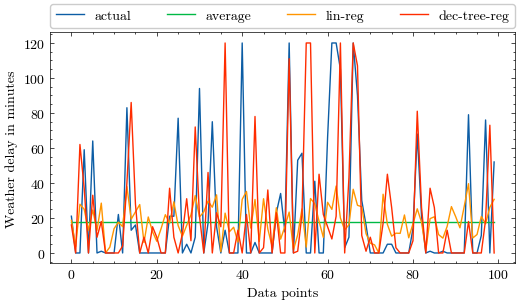

In [23]:
baseline(
    df[(df['Origin'] == 'JFK') | (df['Origin'] == 'FSD') | (df['Origin'] == 'MCO')],
    [
        'CRSElapsedTime',
        'o_temperature_2m',
        'o_relative_humidity_2m',
        'o_dew_point_2m',
        'o_apparent_temperature',
        'o_precipitation',
        'o_rain',
        'o_snowfall',
        'o_snow_depth',
        'o_weather_code',
        'o_surface_pressure',
        'o_cloud_cover',
        'o_cloud_cover_low',
        'o_cloud_cover_mid',
        'o_cloud_cover_high',
        'o_wind_speed_10m',
        'o_wind_speed_100m',
        'o_wind_gusts_10m',
        'o_shortwave_radiation',
        'o_direct_radiation',
        'o_diffuse_radiation',
        'o_direct_normal_irradiance',
        'o_terrestrial_radiation',
        'd_temperature_2m',
        'd_relative_humidity_2m',
        'd_dew_point_2m',
        'd_apparent_temperature',
        'd_precipitation',
        'd_rain',
        'd_snowfall',
        'd_snow_depth',
        'd_weather_code',
        'd_surface_pressure',
        'd_cloud_cover',
        'd_cloud_cover_low',
        'd_cloud_cover_mid',
        'd_cloud_cover_high',
        'd_wind_speed_10m',
        'd_wind_speed_100m',
        'd_wind_gusts_10m',
        'd_shortwave_radiation',
        'd_direct_radiation',
        'd_diffuse_radiation',
        'd_direct_normal_irradiance',
        'd_terrestrial_radiation',
    ]
)

avg model
RMSE: 26.244614196736748
MAE: 17.812806618871704
TPR, FPR: (0.0, 0.0)
linear regression
RMSE: 25.15882077421469
MAE: 16.744330627015344
TPR, FPR: (0.6007785703860469, 0.3734421081618875)
decision tree regression
RMSE: 31.715778661756772
MAE: 18.393417979018306
TPR, FPR: (0.500050171495293, 0.28641558291582275)


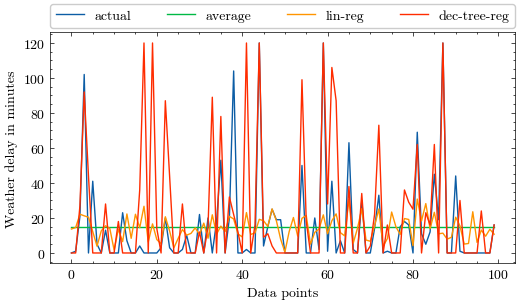

In [39]:
baseline(
    df,
    [
        'CRSElapsedTime',
        'o_temperature_2m',
        'o_relative_humidity_2m',
        'o_dew_point_2m',
        'o_apparent_temperature',
        'o_precipitation',
        'o_rain',
        'o_snowfall',
        'o_snow_depth',
        'o_weather_code',
        'o_surface_pressure',
        'o_cloud_cover',
        'o_cloud_cover_low',
        'o_cloud_cover_mid',
        'o_cloud_cover_high',
        'o_wind_speed_10m',
        'o_wind_speed_100m',
        'o_wind_gusts_10m',
        'o_shortwave_radiation',
        'o_direct_radiation',
        'o_diffuse_radiation',
        'o_direct_normal_irradiance',
        'o_terrestrial_radiation',
        'd_temperature_2m',
        'd_relative_humidity_2m',
        'd_dew_point_2m',
        'd_apparent_temperature',
        'd_precipitation',
        'd_rain',
        'd_snowfall',
        'd_snow_depth',
        'd_weather_code',
        'd_surface_pressure',
        'd_cloud_cover',
        'd_cloud_cover_low',
        'd_cloud_cover_mid',
        'd_cloud_cover_high',
        'd_wind_speed_10m',
        'd_wind_speed_100m',
        'd_wind_gusts_10m',
        'd_shortwave_radiation',
        'd_direct_radiation',
        'd_diffuse_radiation',
        'd_direct_normal_irradiance',
        'd_terrestrial_radiation',
    ]
)

## Advanced models

### Adv 0 - XGBoost

In [23]:
def adv_xgboost_regression(X_train, X_test, Y_train, scaler, grid_search=False, save_model = False, label=""):
    if grid_search:
        print("XGBoost Grid Search:")
        hyperparameter_grid = {
            'n_estimators': [100, 400, 800],
            'max_depth': [6, 9, 12],
            'learning_rate': [0.05, 0.1, 0.20],
            'min_child_weight': [1, 10, 100]
        }
        random_cv = GridSearchCV(estimator=regressor,
                param_grid=hyperparameter_grid,
                cv=5,
                scoring = 'neg_mean_absolute_error',n_jobs = 4,
                verbose = 5, 
                return_train_score = True)
        print(random_cv.best_estimator_)
        regressor = xgb.XGBRegressor(**random_cv.best_estimator_)
    else:
        regressor = xgb.XGBRegressor()#learning_rate=0.05, max_depth=9, min_child_weight=100, n_estimators=400)

    regressor.fit(X_train, Y_train)  
    Y_pred = regressor.predict(X_test)
    
    if save_model and len(label)>0:
        pickle.dump(regressor, open(f'models/xgb-model-{label}.sav', 'wb'))

    return scaler.inverse_transform(Y_pred.reshape(-1, 1)).clip(min=0, max=120)

In [24]:
def adv_decision_tree_regression(X_train, X_test, Y_train, scaler, grid_search=False, save_model=False, label=""):
    regressor = DecisionTreeRegressor(criterion='absolute_error', max_depth=9)
    if grid_search:
        print("Decision Tree Grid Search:")
        hyperparameter_grid = {
            "criterion": ['squared_error', 'friedman_mse', 'absolute_error'],
            "splitter":["best","random"],
            "max_depth" : [3,6,9,12],
            # "min_samples_leaf":[1,2,4,8],
            # "min_weight_fraction_leaf":[0.1,0.2,0.4,0.8],
            "max_features":["log2","sqrt",None],
        }
        random_cv = GridSearchCV(estimator=regressor,
            param_grid=hyperparameter_grid,
            cv=5,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True)
        print(random_cv.best_estimator_)
        regressor = DecisionTreeRegressor(**random_cv.best_estimator_)
    else:
        regressor = DecisionTreeRegressor()#criterion='absolute_error', max_depth=9)
        
    regressor.fit(X_train, Y_train)
    Y_pred = regressor.predict(X_test)

    if save_model and len(label)>0:
        pickle.dump(regressor, open(f'models/dec-tree-model-{label}.sav', 'wb'))

    return scaler.inverse_transform(Y_pred.reshape(-1, 1)).clip(min=0, max=120)

In [25]:
def adv_random_forest_regression(X_train, X_test, Y_train, scaler, grid_search=False, save_model=False, label=""):
    Y_train = Y_train.ravel()
    
    if grid_search:
        print("Random Forest Grid Search:")
        hyperparameter_grid = {
            'n_estimators': [100, 200],
            "criterion": ['squared_error', 'absolute_error'],
            # 'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': [None, 20],
            # 'min_samples_split': [2, 5, 10],
            # 'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
            'random_state': [42]
        }
        random_cv = GridSearchCV(estimator=regressor,
            param_grid=hyperparameter_grid,
            cv=3,
            scoring = 'neg_mean_absolute_error',n_jobs = -1,
            verbose = 5, 
            return_train_score = True)

        print(random_cv.best_estimator_)
        regressor = RandomForestRegressor(**random_cv.best_estimator_)
    else:
        regressor = RandomForestRegressor()#n_estimators=100, criterion='absolute_error')
        
    regressor.fit(X_train, Y_train)
    Y_pred = regressor.predict(X_test)

    if save_model and len(label)>0:
        pickle.dump(regressor, open(f'models/forest-model-{label}.sav', 'wb'))

    return scaler.inverse_transform(Y_pred.reshape(-1, 1)).clip(min=0, max=120)

In [26]:
def adv_nn_regression(X_train, X_test, Y_train, scaler, grid_search=False, save_model=False, label=""):
    Y_train = Y_train.ravel()
    if grid_search:
        print("NN Regression Grid Search:")
        hyperparameter_grid = { 
            "activation": ["identity", "logistic", "tanh", "relu"],
            "solver": ["lbfgs", "sgd", "adam"],
            "alpha": [0.00005, 0.0005, 0.005, 0.05, 0.5]
        }
        random_cv = GridSearchCV(estimator=regressor,
            param_grid=hyperparameter_grid,
            cv=5,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True)
        print(random_cv.best_estimator_)
        regressor = MLPRegressor(**random_cv.best_estimator_)
    else:
        regressor = MLPRegressor()#activation="logistic", alpha=0.005)
        
    regressor.fit(X_train, Y_train)
    Y_pred = regressor.predict(X_test)

    if save_model and len(label)>0:
        pickle.dump(regressor, open(f'models/mlp-model-{label}.sav', 'wb'))

    return scaler.inverse_transform(Y_pred.reshape(-1, 1)).clip(min=0, max=120)

### Run all the advanced models

In [31]:
def advanced_models(df, cols, points_to_plot=100, num_components=30, models = [], grid_search = False, plot = False, label="", save_model = False):
    # df is already cleaned, free of outliers
    df2 = balance_dataset(df)
    
    # process categorical columns
    df2 = apply_funcs(df2,
        [
            # indicate if it is a weekend
            is_weekend,

            # extract day of month from flight date
            get_day_of_month('o_day', 'o'),
            get_day_of_month('d_day', 'd'),

            # extract month from flight date
            get_month('o_day', 'o'),
            get_month('d_day', 'd'),

            cyclical_encode(['o_hour', 'd_hour', 'o_day_of_month', 'd_day_of_month', 'o_month', 'd_month']),

            one_hot_encode(['o_weather_code', 'd_weather_code'])
        ])

    # merge other datasets
    if "o_cluster_labels" not in set(df2.columns):
        df2 = add_cluster_labels(df2)
    df2 = add_weather_features(df2)

    final_cols = list(set(cols) & set(df2.columns))
    X = df2[final_cols]
    Y = df2['WeatherDelay'] + df2['NASDelay']
    Y = Y.clip(upper=120)

    # scale the features
    x_scaler, y_scaler = StandardScaler(), StandardScaler()
    cols_to_scale = [
        'CRSElapsedTime',

        'o_temperature_2m',
        'o_relative_humidity_2m',
        'o_dew_point_2m',
        'o_apparent_temperature',
        'o_precipitation',
        'o_rain',
        'o_snowfall',
        'o_snow_depth',
        'o_surface_pressure',
        'o_cloud_cover',
        'o_cloud_cover_low',
        'o_cloud_cover_mid',
        'o_cloud_cover_high',
        'o_wind_speed_10m',
        'o_wind_speed_100m',
        'o_wind_gusts_10m',
        'o_shortwave_radiation',
        'o_direct_radiation',
        'o_diffuse_radiation',
        'o_direct_normal_irradiance',
        'o_terrestrial_radiation',
        
        'd_temperature_2m',
        'd_relative_humidity_2m',
        'd_dew_point_2m',
        'd_apparent_temperature',
        'd_precipitation',
        'd_rain',
        'd_snowfall',
        'd_snow_depth',
        'd_surface_pressure',
        'd_cloud_cover',
        'd_cloud_cover_low',
        'd_cloud_cover_mid',
        'd_cloud_cover_high',
        'd_wind_speed_10m',
        'd_wind_speed_100m',
        'd_wind_gusts_10m',
        'd_shortwave_radiation',
        'd_direct_radiation',
        'd_diffuse_radiation',
        'd_direct_normal_irradiance',
        'd_terrestrial_radiation', 
        
        'o_elevation_m',
        'd_elevation_m',
        
        'o_temperature_2m_mean',
        'o_relative_humidity_2m_mean',
        'o_dew_point_2m_mean',
        'o_precipitation_sum',
        'o_rain_sum',
        'o_snowfall_sum',
        'o_pressure_msl_mean',
        'o_temp_delta',
        'o_humidity_delta',
        'o_dew_point_delta',
        'o_precipitation_delta',
        
        'd_temperature_2m_mean',
        'd_relative_humidity_2m_mean',
        'd_dew_point_2m_mean',
        'd_precipitation_sum',
        'd_rain_sum',
        'd_snowfall_sum',
        'd_pressure_msl_mean',
        'd_temp_delta',
        'd_humidity_delta',
        'd_dew_point_delta',
        'd_precipitation_delta'
    ]

    # find list of cols to scale from the passed-in cols
    final_cols_to_scale = list(set(cols_to_scale) & set(X.columns))

    X[final_cols_to_scale] = x_scaler.fit_transform(X[final_cols_to_scale])
    Y = y_scaler.fit_transform(Y.values.reshape(-1, 1))

    # pca
    if num_components > 0:
        X = dim_reduction(X, num_components)

    model_pop = X.shape[0]
    # test train split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
    Y_test = y_scaler.inverse_transform(Y_test.reshape(-1, 1))
    
    if plot:
        plt.figure(1)
        points_to_plot = min(points_to_plot, len(Y_test))
        plt.plot(range(points_to_plot), Y_test[:points_to_plot], label="actual")

    model_errors = []
    # xgboost
    if "xgb" in models:
        y_xgb_pred = adv_xgboost_regression(X_train, X_test, Y_train, y_scaler, grid_search, save_model, label)
        print("xgboost")
        model_errors.append((label, model_pop, "xgb", *print_metrics(Y_test, y_xgb_pred)))
        if plot:
            plt.plot(range(points_to_plot), y_xgb_pred[:points_to_plot], label="xgb", marker=".", markersize=1)

    # mlp
    if "mlp" in models:
        y_mlp_pred = adv_nn_regression(X_train, X_test, Y_train, y_scaler, grid_search, save_model, label)
        print("mlp")
        model_errors.append((label, model_pop, "mlp", *print_metrics(Y_test, y_mlp_pred)))
        if plot:
            plt.plot(range(points_to_plot), y_mlp_pred[:points_to_plot], label="mlp", marker=".", markersize=1)

    # adv_decision_tree_regression
    if "dec_tree" in models:
        y_dec_tree_pred = adv_decision_tree_regression(X_train, X_test, Y_train, y_scaler, grid_search, save_model, label)
        print("dec_tree")
        model_errors.append((label, model_pop, "dec_tree", *print_metrics(Y_test, y_dec_tree_pred)))
        if plot:
            plt.plot(range(points_to_plot), y_dec_tree_pred[:points_to_plot], label="decision-tree", marker=".", markersize=1)

    if "forest" in models:
        y_forest_pred = adv_random_forest_regression(X_train, X_test, Y_train, y_scaler, grid_search, save_model, label)
        print("forest")
        model_errors.append((label, model_pop, "forest", *print_metrics(Y_test, y_forest_pred)))
        if plot:
            plt.plot(range(points_to_plot), y_forest_pred[:points_to_plot], label="random-forest", marker=".", markersize=1)

    if plot:
        plt.legend(frameon=True,
                   framealpha=1,
                   bbox_to_anchor=(0, 1.02, 1, 0.2),
                   loc="lower left",
                   mode="expand",
                   borderaxespad=0,
                   ncol=5)
    
        plt.ylabel("Weather delay in minutes")
        plt.xlabel("Data points")
        plt.savefig("advanced.eps", bbox_inches="tight")
        plt.show()

    return model_errors

/tmp/ipykernel_29056/3105728855.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[final_cols_to_scale] = x_scaler.fit_transform(X[final_cols_to_scale])


xgboost
RMSE: 24.479577378633323
MAE: 16.248159358633952
607906 293424 180149 257593
TPR, FPR: (0.5884584983848934, 0.32554558263898903)


/home/shared/code/my-venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mlp
RMSE: 24.055155288760186
MAE: 15.089263488754824
685185 216145 212276 225466
TPR, FPR: (0.5150659520905008, 0.23980673005447506)


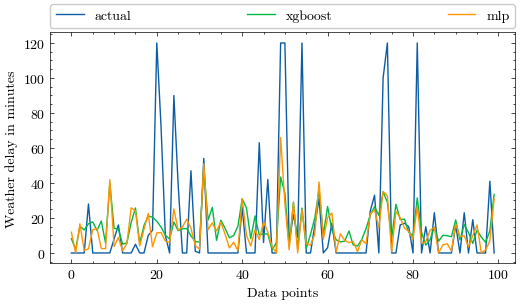

In [58]:
advanced_models(
    df,
    [
        'CRSElapsedTime',
        
        #'o_temperature_2m',
        #'o_relative_humidity_2m',
        #'o_dew_point_2m',
        'o_apparent_temperature',
        #'o_precipitation',
        'o_rain',
        'o_snowfall',
        'o_snow_depth',
        'o_surface_pressure',
        'o_cloud_cover',
        'o_cloud_cover_low',
        'o_cloud_cover_mid',
        'o_cloud_cover_high',
        'o_wind_speed_10m',
        'o_wind_speed_100m',
        'o_wind_gusts_10m',
        'o_shortwave_radiation',
        'o_direct_radiation',
        'o_diffuse_radiation',
        'o_direct_normal_irradiance',
        'o_terrestrial_radiation',
        
        #'d_temperature_2m',
        #'d_relative_humidity_2m',
        #'d_dew_point_2m',
        'd_apparent_temperature',
        #'d_precipitation',
        'd_rain',
        'd_snowfall',
        'd_snow_depth',
        'd_surface_pressure',
        'd_cloud_cover',
        'd_cloud_cover_low',
        'd_cloud_cover_mid',
        'd_cloud_cover_high',
        'd_wind_speed_10m',
        'd_wind_speed_100m',
        'd_wind_gusts_10m',
        'd_shortwave_radiation',
        'd_direct_radiation',
        'd_diffuse_radiation',
        'd_direct_normal_irradiance',
        'd_terrestrial_radiation',
        
        'weekend',
        'o_hour_sin',
        'o_hour_cos',
        'd_hour_sin',
        'd_hour_cos',
        'o_day_of_month_sin',
        'o_day_of_month_cos',
        'd_day_of_month_sin',
        'd_day_of_month_cos',
        'o_month_sin',
        'o_month_cos',
        'd_month_sin',
        'd_month_cos',
        
        'o_weather_code_0.0',
        'o_weather_code_51.0',
        'o_weather_code_1.0',
        'o_weather_code_3.0',
        'o_weather_code_2.0',
        'o_weather_code_55.0',
        'o_weather_code_63.0',
        'o_weather_code_61.0',
        'o_weather_code_71.0',
        'o_weather_code_53.0',
        'o_weather_code_73.0',
        'o_weather_code_75.0',
        'o_weather_code_65.0',
        
        'd_weather_code_1.0',
        'd_weather_code_3.0',
        'd_weather_code_0.0',
        'd_weather_code_51.0',
        'd_weather_code_2.0',
        'd_weather_code_63.0',
        'd_weather_code_61.0',
        'd_weather_code_53.0',
        'd_weather_code_73.0',
        'd_weather_code_65.0',
        'd_weather_code_55.0',
        'd_weather_code_71.0',
        'd_weather_code_75.0',
        
        'o_elevation_m',
        'd_elevation_m',
        
        'o_temp_delta',
        'o_humidity_delta',
        'o_dew_point_delta',
        'o_precipitation_delta',
        
        'd_temp_delta',
        'd_humidity_delta',
        'd_dew_point_delta',
        'd_precipitation_delta'
    ]
)

/tmp/ipykernel_29056/3105728855.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[final_cols_to_scale] = x_scaler.fit_transform(X[final_cols_to_scale])


xgboost
RMSE: 25.018936560811095
MAE: 16.673866212537007
610112 290895 199937 238128
TPR, FPR: (0.5435905630442971, 0.32285542731632494)


/home/shared/code/my-venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mlp
RMSE: 25.136101282275565
MAE: 16.501203168330854
625706 275301 210506 227559
TPR, FPR: (0.5194640064830561, 0.3055481255972484)


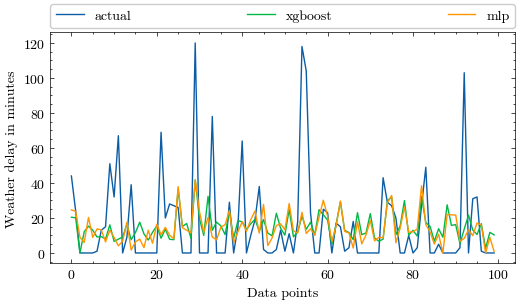

In [59]:
advanced_models(
    df,
    # df[(df['Origin'] == 'JFK')],
    [
        'CRSElapsedTime',
        
        'o_temperature_2m',
        'o_relative_humidity_2m',
        'o_dew_point_2m',
        'o_apparent_temperature',
        'o_precipitation',
        'o_rain',
        'o_snowfall',
        'o_snow_depth',
        'o_surface_pressure',
        'o_cloud_cover',
        'o_cloud_cover_low',
        'o_cloud_cover_mid',
        'o_cloud_cover_high',
        'o_wind_speed_10m',
        'o_wind_speed_100m',
        'o_wind_gusts_10m',
        'o_shortwave_radiation',
        'o_direct_radiation',
        'o_diffuse_radiation',
        'o_direct_normal_irradiance',
        'o_terrestrial_radiation',
        
        # #'d_temperature_2m',
        # #'d_relative_humidity_2m',
        # #'d_dew_point_2m',
        # 'd_apparent_temperature',
        # #'d_precipitation',
        # 'd_rain',
        # 'd_snowfall',
        # 'd_snow_depth',
        # 'd_surface_pressure',
        # 'd_cloud_cover',
        # 'd_cloud_cover_low',
        # 'd_cloud_cover_mid',
        # 'd_cloud_cover_high',
        # 'd_wind_speed_10m',
        # 'd_wind_speed_100m',
        # 'd_wind_gusts_10m',
        # 'd_shortwave_radiation',
        # 'd_direct_radiation',
        # 'd_diffuse_radiation',
        # 'd_direct_normal_irradiance',
        # 'd_terrestrial_radiation',
        
        'weekend',
        'o_hour_sin',
        'o_hour_cos',
        # 'd_hour_sin',
        # 'd_hour_cos',
        'o_day_of_month_sin',
        'o_day_of_month_cos',
        # 'd_day_of_month_sin',
        # 'd_day_of_month_cos',
        'o_month_sin',
        'o_month_cos',
        # 'd_month_sin',
        # 'd_month_cos',
        
        'o_weather_code_0.0',
        'o_weather_code_51.0',
        'o_weather_code_1.0',
        'o_weather_code_3.0',
        'o_weather_code_2.0',
        'o_weather_code_55.0',
        'o_weather_code_63.0',
        'o_weather_code_61.0',
        'o_weather_code_71.0',
        'o_weather_code_53.0',
        'o_weather_code_73.0',
        'o_weather_code_75.0',
        'o_weather_code_65.0',
        
        # 'd_weather_code_1.0',
        # 'd_weather_code_3.0',
        # 'd_weather_code_0.0',
        # 'd_weather_code_51.0',
        # 'd_weather_code_2.0',
        # 'd_weather_code_63.0',
        # 'd_weather_code_61.0',
        # 'd_weather_code_53.0',
        # 'd_weather_code_73.0',
        # 'd_weather_code_65.0',
        # 'd_weather_code_55.0',
        # 'd_weather_code_71.0',
        # 'd_weather_code_75.0',
        
        'o_elevation_m',
        # 'd_elevation_m',
        
        # 'o_temp_delta',
        # 'o_humidity_delta',
        # 'o_dew_point_delta',
        # 'o_precipitation_delta',
        
        # 'd_temp_delta',
        # 'd_humidity_delta',
        # 'd_dew_point_delta',
        # 'd_precipitation_delta'
    ]
)

/tmp/ipykernel_357095/622048666.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[final_cols_to_scale] = x_scaler.fit_transform(X[final_cols_to_scale])


xgboost
13079 5352 3861 7476
RMSE: 23.944720982247286
MAE: 15.916677847697088
Accuracy, TPR, FPR: (0.6905065842515453, 0.6594337126223869, 0.2903803374749064)
mlp
12587 5844 4096 7241
RMSE: 24.59277673327085
MAE: 16.14176781419157
Accuracy, TPR, FPR: (0.6660843859177641, 0.6387051248125606, 0.31707449405892246)
dec_tree
13272 5159 4535 6802
RMSE: 31.460334744798413
MAE: 18.193222028128638
Accuracy, TPR, FPR: (0.6743482934694974, 0.5999823586486724, 0.27990884922142045)
forest
13373 5058 3935 7402
RMSE: 24.871652280287112
MAE: 16.155010417999726
Accuracy, TPR, FPR: (0.6978970706799248, 0.6529064126312075, 0.27442895122348215)


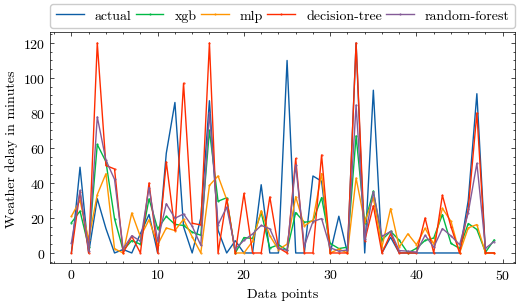

[('',
  90204,
  'xgb',
  23.944720982247286,
  15.916677847697088,
  0.6905065842515453,
  0.6594337126223869,
  0.2903803374749064),
 ('',
  90204,
  'mlp',
  24.59277673327085,
  16.14176781419157,
  0.6660843859177641,
  0.6387051248125606,
  0.31707449405892246),
 ('',
  90204,
  'dec_tree',
  31.460334744798413,
  18.193222028128638,
  0.6743482934694974,
  0.5999823586486724,
  0.27990884922142045),
 ('',
  90204,
  'forest',
  24.871652280287112,
  16.155010417999726,
  0.6978970706799248,
  0.6529064126312075,
  0.27442895122348215)]

In [32]:
advanced_models(
    df[(df['Origin'] == 'JFK')],
    [
        'CRSElapsedTime',
        
        'o_temperature_2m',
        'o_relative_humidity_2m',
        'o_dew_point_2m',
        'o_apparent_temperature',
        'o_precipitation',
        'o_rain',
        'o_snowfall',
        'o_snow_depth',
        'o_surface_pressure',
        'o_cloud_cover',
        'o_cloud_cover_low',
        'o_cloud_cover_mid',
        'o_cloud_cover_high',
        'o_wind_speed_10m',
        'o_wind_speed_100m',
        'o_wind_gusts_10m',
        'o_shortwave_radiation',
        'o_direct_radiation',
        'o_diffuse_radiation',
        'o_direct_normal_irradiance',
        'o_terrestrial_radiation',
        
        # #'d_temperature_2m',
        # #'d_relative_humidity_2m',
        # #'d_dew_point_2m',
        # 'd_apparent_temperature',
        # #'d_precipitation',
        # 'd_rain',
        # 'd_snowfall',
        # 'd_snow_depth',
        # 'd_surface_pressure',
        # 'd_cloud_cover',
        # 'd_cloud_cover_low',
        # 'd_cloud_cover_mid',
        # 'd_cloud_cover_high',
        # 'd_wind_speed_10m',
        # 'd_wind_speed_100m',
        # 'd_wind_gusts_10m',
        # 'd_shortwave_radiation',
        # 'd_direct_radiation',
        # 'd_diffuse_radiation',
        # 'd_direct_normal_irradiance',
        # 'd_terrestrial_radiation',
        
        'weekend',
        'o_hour_sin',
        'o_hour_cos',
        # 'd_hour_sin',
        # 'd_hour_cos',
        'o_day_of_month_sin',
        'o_day_of_month_cos',
        # 'd_day_of_month_sin',
        # 'd_day_of_month_cos',
        'o_month_sin',
        'o_month_cos',
        # 'd_month_sin',
        # 'd_month_cos',
        
        'o_weather_code_0.0',
        'o_weather_code_51.0',
        'o_weather_code_1.0',
        'o_weather_code_3.0',
        'o_weather_code_2.0',
        'o_weather_code_55.0',
        'o_weather_code_63.0',
        'o_weather_code_61.0',
        'o_weather_code_71.0',
        'o_weather_code_53.0',
        'o_weather_code_73.0',
        'o_weather_code_75.0',
        'o_weather_code_65.0',
        
        # 'd_weather_code_1.0',
        # 'd_weather_code_3.0',
        # 'd_weather_code_0.0',
        # 'd_weather_code_51.0',
        # 'd_weather_code_2.0',
        # 'd_weather_code_63.0',
        # 'd_weather_code_61.0',
        # 'd_weather_code_53.0',
        # 'd_weather_code_73.0',
        # 'd_weather_code_65.0',
        # 'd_weather_code_55.0',
        # 'd_weather_code_71.0',
        # 'd_weather_code_75.0',
        
        'o_elevation_m',
        # 'd_elevation_m',
        
        # 'o_temp_delta',
        # 'o_humidity_delta',
        # 'o_dew_point_delta',
        # 'o_precipitation_delta',
        
        # 'd_temp_delta',
        # 'd_humidity_delta',
        # 'd_dew_point_delta',
        # 'd_precipitation_delta'
    ], models = ['xgb', 'mlp', 'dec_tree', 'forest'], plot=True, points_to_plot=50
)

In [102]:
advanced_models(
    df[(df['Origin'] == 'JFK')],
    [
        'CRSElapsedTime',
        
        'o_temperature_2m',
        'o_relative_humidity_2m',
        'o_dew_point_2m',
        'o_apparent_temperature',
        'o_precipitation',
        'o_rain',
        'o_snowfall',
        'o_snow_depth',
        'o_surface_pressure',
        'o_cloud_cover',
        # 'o_cloud_cover_low',
        # 'o_cloud_cover_mid',
        # 'o_cloud_cover_high',
        'o_wind_speed_10m',
        # 'o_wind_speed_100m',
        'o_wind_gusts_10m',
        # 'o_shortwave_radiation',
        'o_direct_radiation',
        # 'o_diffuse_radiation',
        # 'o_direct_normal_irradiance',
        # 'o_terrestrial_radiation',
        
        # #'d_temperature_2m',
        # #'d_relative_humidity_2m',
        # #'d_dew_point_2m',
        # 'd_apparent_temperature',
        # #'d_precipitation',
        # 'd_rain',
        # 'd_snowfall',
        # 'd_snow_depth',
        # 'd_surface_pressure',
        # 'd_cloud_cover',
        # 'd_cloud_cover_low',
        # 'd_cloud_cover_mid',
        # 'd_cloud_cover_high',
        # 'd_wind_speed_10m',
        # 'd_wind_speed_100m',
        # 'd_wind_gusts_10m',
        # 'd_shortwave_radiation',
        # 'd_direct_radiation',
        # 'd_diffuse_radiation',
        # 'd_direct_normal_irradiance',
        # 'd_terrestrial_radiation',
        
        'weekend',
        'o_hour_sin',
        'o_hour_cos',
        # 'd_hour_sin',
        # 'd_hour_cos',
        'o_day_of_month_sin',
        'o_day_of_month_cos',
        # 'd_day_of_month_sin',
        # 'd_day_of_month_cos',
        'o_month_sin',
        'o_month_cos',
        # 'd_month_sin',
        # 'd_month_cos',
        
        # 'o_weather_code_0.0',
        # 'o_weather_code_51.0',
        # 'o_weather_code_1.0',
        # 'o_weather_code_3.0',
        # 'o_weather_code_2.0',
        # 'o_weather_code_55.0',
        # 'o_weather_code_63.0',
        # 'o_weather_code_61.0',
        # 'o_weather_code_71.0',
        # 'o_weather_code_53.0',
        # 'o_weather_code_73.0',
        # 'o_weather_code_75.0',
        # 'o_weather_code_65.0',
        
        # 'd_weather_code_1.0',
        # 'd_weather_code_3.0',
        # 'd_weather_code_0.0',
        # 'd_weather_code_51.0',
        # 'd_weather_code_2.0',
        # 'd_weather_code_63.0',
        # 'd_weather_code_61.0',
        # 'd_weather_code_53.0',
        # 'd_weather_code_73.0',
        # 'd_weather_code_65.0',
        # 'd_weather_code_55.0',
        # 'd_weather_code_71.0',
        # 'd_weather_code_75.0',
        
        'o_elevation_m',
        # 'd_elevation_m',
        
        # 'o_temp_delta',
        # 'o_humidity_delta',
        # 'o_dew_point_delta',
        # 'o_precipitation_delta',
        
        # 'd_temp_delta',
        # 'd_humidity_delta',
        # 'd_dew_point_delta',
        # 'd_precipitation_delta'
    ], 100, 20
)

XGBoost Grid Search:
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/tmp/ipykernel_29056/4045277925.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[final_cols_to_scale] = x_scaler.fit_transform(X[final_cols_to_scale])


[CV 2/5] END learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100;, score=(train=-0.582, test=-0.603) total time=   0.3s
[CV 1/5] END learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=400;, score=(train=-0.501, test=-0.579) total time=   1.0s
[CV 5/5] END learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=400;, score=(train=-0.505, test=-0.572) total time=   1.0s
[CV 4/5] END learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=800;, score=(train=-0.442, test=-0.556) total time=   2.0s
[CV 2/5] END learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=400;, score=(train=-0.507, test=-0.571) total time=   1.0s
[CV 5/5] END learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=400;, score=(train=-0.508, test=-0.572) total time=   1.0s
[CV 4/5] END learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=800;, score=(train=-0.455, test=-0.555) total time=   2.4s
[CV 3/5] END learning_rate=0.05

/home/shared/code/my-venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5] END learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100;, score=(train=-0.578, test=-0.611) total time=   0.3s
[CV 5/5] END learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100;, score=(train=-0.581, test=-0.604) total time=   0.3s
[CV 3/5] END learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=400;, score=(train=-0.501, test=-0.584) total time=   1.0s
[CV 2/5] END learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=800;, score=(train=-0.440, test=-0.563) total time=   2.0s
[CV 2/5] END learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=100;, score=(train=-0.583, test=-0.603) total time=   0.3s
[CV 4/5] END learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=100;, score=(train=-0.586, test=-0.596) total time=   0.3s
[CV 1/5] END learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=400;, score=(train=-0.508, test=-0.579) total time=   1.0s
[CV 4/5] END learning_rate=0.05

In [21]:
common_features = [
    'CRSElapsedTime',
    'weekend',
]

prefix_features = [
    'temperature_2m',
    'relative_humidity_2m',
    'dew_point_2m',
    'apparent_temperature',
    'precipitation',
    'rain',
    'snowfall',
    'snow_depth',
    'surface_pressure',
    'cloud_cover',
    'cloud_cover_low',
    'cloud_cover_mid',
    'cloud_cover_high',
    'wind_speed_10m',
    'wind_speed_100m',
    'wind_gusts_10m',
    'shortwave_radiation',
    'direct_radiation',
    'diffuse_radiation',
    'direct_normal_irradiance',
    'terrestrial_radiation',

    'hour_sin',
    'hour_cos',
    'day_of_month_sin',
    'day_of_month_cos',
    'month_sin',
    'month_cos',

    'weather_code_0.0',
    'weather_code_1.0',
    'weather_code_2.0',
    'weather_code_3.0',
    'weather_code_51.0',
    'weather_code_53.0',
    'weather_code_55.0',
    'weather_code_61.0',
    'weather_code_63.0',
    'weather_code_65.0',
    'weather_code_71.0',
    'weather_code_73.0',
    'weather_code_75.0',
    
    'elevation_m',
    
    'temp_delta',
    'humidity_delta',
    'dew_point_delta',
    'precipitation_delta',
]

In [20]:
# Give full df, not sampled.
def train_cluster(df, models, prefix='o_'):
    model_errors = []
    features = common_features + [prefix+ft for ft in prefix_features]
    clusters = df.groupby(prefix+'cluster_labels')
    print("Grouped by clusters")
    for cluster, cluster_df in clusters:
        pop = cluster_df.shape[0]
        print("*"*80)
        print(f"Training cluster {cluster}, size={pop}")
        err = advanced_models(cluster_df, features, models=models, label=f'{prefix}cluster{cluster}', save_model=False, plot=False)
        print("Model errors:")
        for e in err:
            print(e)
        print("*"*80)
        model_errors.extend(err)
    return model_errors

def predict_cluster(df, features):
    model_errors = []
    clusters = df.groupby('cluster_labels')
    for cluster, cluster_df in clusters:
        X_test = cluster_df[features]
        loaded_model = pickle.load(open(f'model-{cluster}.sav', 'rb'))
        Y_pred = loaded_model.predict(X_test).clip(min=0, max=120)
        rmse = mean_squared_error(Y_test, Y_pred, squared=False)
        mae = mean_absolute_error(Y_test, Y_pred)
        model_errors.append((cluster, rmse, mae))
    return model_errors

In [27]:
df = add_cluster_labels(df)
print("Added cluster labels")

Added cluster labels


In [19]:
# o_cluster_model_errors = train_cluster(df, ['xgb'], 'o_')
# df.columns

In [44]:
o_cluster_model_errors = cluster_model_errors

In [18]:
# d_cluster_model_errors = train_cluster(df, ['xgb'], 'd_')

In [47]:
o_err_df = pd.DataFrame(o_cluster_model_errors, columns=['cluster', 'size', 'model', 'rmse', 'mae', 'accuracy', 'tpr', 'fpr'])
d_err_df = pd.DataFrame(d_cluster_model_errors, columns=['cluster', 'size', 'model', 'rmse', 'mae', 'accuracy', 'tpr', 'fpr'])

In [57]:
o_err_df.sort_values(['rmse'], ascending=True)

,cluster,size,model,rmse,mae,accuracy,tpr,fpr
23,o_cluster23,320,xgb,12.506409,7.210503,0.830189,0.000000,0.000000
6,o_cluster6,19396,xgb,12.821736,8.354741,0.728480,0.315616,0.106862
19,o_cluster19,1222,xgb,14.347341,9.335359,0.727723,0.212766,0.116129
3,o_cluster3,8756,xgb,15.457384,10.142622,0.697232,0.237385,0.104063
14,o_cluster14,4720,xgb,16.606378,9.658554,0.761232,0.203438,0.077750
2,o_cluster2,340,xgb,17.091841,10.386140,0.752212,0.068966,0.011905
12,o_cluster12,16388,xgb,17.806457,11.402514,0.696062,0.194659,0.124937
1,o_cluster1,225140,xgb,20.859041,13.430762,0.697929,0.388726,0.171131
8,o_cluster8,34,xgb,20.863075,19.090909,0.333333,1.000000,1.000000
7,o_cluster7,174166,xgb,21.824594,14.025456,0.702549,0.570085,0.232994


In [54]:
d_err_df.sort_values(['accuracy'], ascending=False)

,cluster,size,model,rmse,mae,accuracy,tpr,fpr
2,d_cluster2,386,xgb,12.890136,8.262678,0.757812,0.035714,0.040000
1,d_cluster1,282074,xgb,23.198904,15.331141,0.743245,0.700948,0.234536
18,d_cluster18,412984,xgb,24.593515,16.822843,0.728620,0.714458,0.263012
21,d_cluster21,457858,xgb,18.631404,12.107687,0.722504,0.430954,0.149485
14,d_cluster14,4996,xgb,15.464616,9.770433,0.722256,0.185567,0.112609
25,d_cluster25,385134,xgb,21.794113,14.301210,0.719816,0.544853,0.194737
26,d_cluster26,30882,xgb,19.649444,12.087960,0.719486,0.323095,0.151204
7,d_cluster7,153230,xgb,20.710208,13.474202,0.715599,0.522209,0.189377
27,d_cluster27,428512,xgb,25.260954,17.127572,0.713703,0.714196,0.286587
6,d_cluster6,25818,xgb,16.240738,10.021179,0.712441,0.523099,0.194182


In [58]:
df.columns

Index(['DayOfWeek', 'FlightDate', 'IATA_CODE_Reporting_Airline', 'Tail_Number',
       'Flight_Number_Reporting_Airline', 'OriginAirportID', 'Origin',
       'OriginState', 'DestAirportID', 'Dest', 'DestState', 'CRSDepTime',
       'DepTime', 'DepDelayMinutes', 'CRSArrTime', 'ArrTime',
       'ArrDelayMinutes', 'Cancelled', 'Diverted', 'CRSElapsedTime',
       'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay',
       'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CRSDepHour',
       'OriginTz', 'DestTz', 'CRSArrDateTime', 'CRSArrDate', 'CRSArrHour',
       'o_temperature_2m', 'o_relative_humidity_2m', 'o_dew_point_2m',
       'o_apparent_temperature', 'o_precipitation', 'o_rain', 'o_snowfall',
       'o_snow_depth', 'o_weather_code', 'o_surface_pressure', 'o_cloud_cover',
       'o_cloud_cover_low', 'o_cloud_cover_mid', 'o_cloud_cover_high',
       'o_wind_speed_10m', 'o_wind_speed_100m', 'o_wind_gusts_10m',
       'o_shortwave_radiation', 'o_direct_radiation', 'o_diff

In [24]:
# week_df = df.groupby('DayOfWeek')

In [18]:
df.columns

Index(['DayOfWeek', 'FlightDate', 'IATA_CODE_Reporting_Airline', 'Tail_Number',
       'Flight_Number_Reporting_Airline', 'OriginAirportID', 'Origin',
       'OriginState', 'DestAirportID', 'Dest', 'DestState', 'CRSDepTime',
       'DepTime', 'DepDelayMinutes', 'CRSArrTime', 'ArrTime',
       'ArrDelayMinutes', 'Cancelled', 'Diverted', 'CRSElapsedTime',
       'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay',
       'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CRSDepHour',
       'OriginTz', 'DestTz', 'CRSArrDateTime', 'CRSArrDate', 'CRSArrHour',
       'o_temperature_2m', 'o_relative_humidity_2m', 'o_dew_point_2m',
       'o_apparent_temperature', 'o_precipitation', 'o_rain', 'o_snowfall',
       'o_snow_depth', 'o_weather_code', 'o_surface_pressure', 'o_cloud_cover',
       'o_cloud_cover_low', 'o_cloud_cover_mid', 'o_cloud_cover_high',
       'o_wind_speed_10m', 'o_wind_speed_100m', 'o_wind_gusts_10m',
       'o_shortwave_radiation', 'o_direct_radiation', 'o_diff

<Axes: title={'center': 'DepDelayMinutes'}, xlabel='DayOfWeek'>

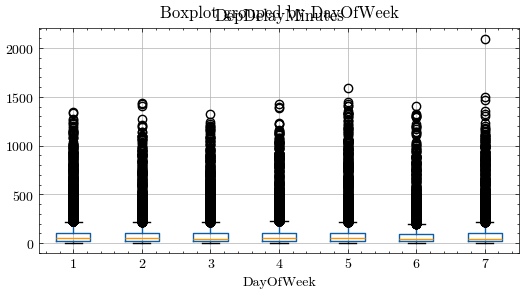

In [20]:
df[(df['NASDelay']>0) & (df['WeatherDelay']>0)].boxplot(column='DepDelayMinutes', by='DayOfWeek')

array([[<Axes: title={'center': 'DayOfWeek'}>]], dtype=object)

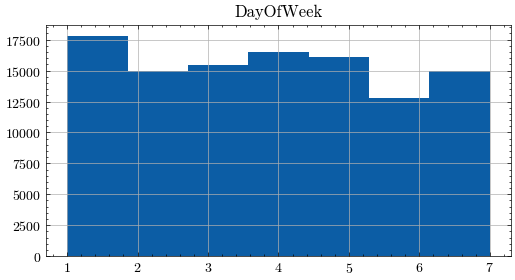

In [25]:
df[(df['NASDelay']>0) & (df['WeatherDelay']>0)].hist('DayOfWeek', bins=7)

In [26]:
# df[(df['NASDelay']>0) & (df['WeatherDelay']>0)].groupby('DayOfWeek')[]
df['Target'] = df['NASDelay'] + df['WeatherDelay']

In [27]:
df[df['Target']>0].groupby('DayOfWeek')['Target'].mean()

DayOfWeek
1    35.141251
2    35.769354
3    35.358087
4    34.456989
5    33.831475
6    33.309514
7    34.068835
Name: Target, dtype: float64

In [28]:
def predict_cluster(x, cluster, prefix):
    # o_cluster = x['o_cluster_labels']
    # d_cluster = x['d_cluster_labels']
    
    loaded_model = pickle.load(open(f'models/xgb-model-{prefix}cluster{o_cluster}.sav', 'rb'))
    # d_loaded_model = pickle.load(open(f'models/xgb-model-d_cluster{d_cluster}.sav', 'rb'))

    y_pred = loaded_model.predict(x[features])
    # d_y_pred = loaded_model.predict(x[features])

    # y_pred = (o_y_pred+d_y_pred)/2
    # y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).clip(min=0, max=120)
    # model_errors = []
    # clusters = df.groupby('cluster_labels')
    # for cluster, cluster_df in clusters:
    #     X_test = cluster_df[features]
    #     loaded_model = pickle.load(open(f'model-{cluster}.sav', 'rb'))
    #     Y_pred = loaded_model.predict(X_test).clip(min=0, max=120)
    #     rmse = mean_squared_error(Y_test, Y_pred, squared=False)
    #     mae = mean_absolute_error(Y_test, Y_pred)
    #     model_errors.append((cluster, rmse, mae))
    return y_pred

In [65]:
def predict_cluster_models(df, cols, prefix, points_to_plot=100, num_components=30, plot = True):
    # df is already cleaned, free of outliers
    # df2 = balance_dataset(df)
    
    # process categorical columns
    df2 = apply_funcs(df,
        [
            # indicate if it is a weekend
            is_weekend,

            # extract day of month from flight date
            get_day_of_month('o_day', 'o'),
            get_day_of_month('d_day', 'd'),

            # extract month from flight date
            get_month('o_day', 'o'),
            get_month('d_day', 'd'),

            cyclical_encode(['o_hour', 'd_hour', 'o_day_of_month', 'd_day_of_month', 'o_month', 'd_month']),

            one_hot_encode(['o_weather_code', 'd_weather_code'])
        ])

    # merge other datasets
    if "o_cluster_labels" not in set(df2.columns):
        df2 = add_cluster_labels(df2)

    df_cluster_labels = df2[['o_cluster_labels', 'd_cluster_labels']]
    df2 = add_weather_features(df2)

    
    final_cols = list(set(cols) & set(df2.columns))
    X = df2[final_cols]
    Y = df2['WeatherDelay'] + df2['NASDelay']
    Y = Y.clip(upper=120)

    # scale the features
    x_scaler, y_scaler = StandardScaler(), StandardScaler()
    cols_to_scale = [
        'CRSElapsedTime',

        'o_temperature_2m',
        'o_relative_humidity_2m',
        'o_dew_point_2m',
        'o_apparent_temperature',
        'o_precipitation',
        'o_rain',
        'o_snowfall',
        'o_snow_depth',
        'o_surface_pressure',
        'o_cloud_cover',
        'o_cloud_cover_low',
        'o_cloud_cover_mid',
        'o_cloud_cover_high',
        'o_wind_speed_10m',
        'o_wind_speed_100m',
        'o_wind_gusts_10m',
        'o_shortwave_radiation',
        'o_direct_radiation',
        'o_diffuse_radiation',
        'o_direct_normal_irradiance',
        'o_terrestrial_radiation',
        
        'd_temperature_2m',
        'd_relative_humidity_2m',
        'd_dew_point_2m',
        'd_apparent_temperature',
        'd_precipitation',
        'd_rain',
        'd_snowfall',
        'd_snow_depth',
        'd_surface_pressure',
        'd_cloud_cover',
        'd_cloud_cover_low',
        'd_cloud_cover_mid',
        'd_cloud_cover_high',
        'd_wind_speed_10m',
        'd_wind_speed_100m',
        'd_wind_gusts_10m',
        'd_shortwave_radiation',
        'd_direct_radiation',
        'd_diffuse_radiation',
        'd_direct_normal_irradiance',
        'd_terrestrial_radiation', 
        
        'o_elevation_m',
        'd_elevation_m',
        
        'o_temperature_2m_mean',
        'o_relative_humidity_2m_mean',
        'o_dew_point_2m_mean',
        'o_precipitation_sum',
        'o_rain_sum',
        'o_snowfall_sum',
        'o_pressure_msl_mean',
        'o_temp_delta',
        'o_humidity_delta',
        'o_dew_point_delta',
        'o_precipitation_delta',
        
        'd_temperature_2m_mean',
        'd_relative_humidity_2m_mean',
        'd_dew_point_2m_mean',
        'd_precipitation_sum',
        'd_rain_sum',
        'd_snowfall_sum',
        'd_pressure_msl_mean',
        'd_temp_delta',
        'd_humidity_delta',
        'd_dew_point_delta',
        'd_precipitation_delta'
    ]

    # find list of cols to scale from the passed-in cols
    final_cols_to_scale = list(set(cols_to_scale) & set(X.columns))

    X[final_cols_to_scale] = x_scaler.fit_transform(X[final_cols_to_scale])
    # Y = y_scaler.fit_transform(Y.values.reshape(-1, 1))

    cluster_cols = ['o_cluster_labels', 'd_cluster_labels']
    # final_cols = [col for col in X.columns if col not in cluster_cols]
    
    # pca
    if num_components > 0:
        X = dim_reduction(X, num_components)

    print(type(X))
    print("shape",X.shape)
    X = pd.DataFrame(X)
    features = X.columns
    print("Before adding cluster columns back: ", X.columns, X.shape)
    X[cluster_cols] = df_cluster_labels
    print("After adding cluster columns back: ", X.columns, X.shape)

    # model_pop = X.shape[0]
    # # test train split
    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
    # Y_test = y_scaler.inverse_transform(Y_test.reshape(-1, 1))

    Y_test = Y

    if plot:
        plt.figure(1)
        points_to_plot = min(points_to_plot, len(Y_test))
        plt.plot(range(points_to_plot), Y_test[:points_to_plot], label="actual")

    cluster = prefix+"cluster_labels"
    print("CLUSTER LABEL:", cluster)
    def func(row):
        print(row[features])
        return predict_cluster(row[features], row[cluster], prefix)
        
    Y_pred = X.apply(func)
    Y_pred = y_scaler.inverse_transform(Y_pred.reshape(-1, 1)).clip(0,120)

    if plot:
        plt.plot(range(points_to_plot), Y_pred[:points_to_plot], label="predicted")
    
    # model_errors = []
    # xgboost
    # if "xgb" in models:
    #     y_xgb_pred = adv_xgboost_regression(X_train, X_test, Y_train, y_scaler, grid_search, save_model, label)
    #     print("xgboost")
    #     model_errors.append((label, model_pop, "xgb", *print_metrics(Y_test, y_xgb_pred)))
    #     if plot:
    #         plt.plot(range(points_to_plot), y_xgb_pred[:points_to_plot], label="xgboost")

    # # mlp
    # if "mlp" in models:
    #     y_mlp_pred = adv_nn_regression(X_train, X_test, Y_train, y_scaler, grid_search, save_model, label)
    #     print("mlp")
    #     model_errors.append((label, model_pop, "mlp", *print_metrics(Y_test, y_mlp_pred)))
    #     if plot:
    #         plt.plot(range(points_to_plot), y_mlp_pred[:points_to_plot], label="mlp")

    # # adv_decision_tree_regression
    # if "dec_tree" in models:
    #     y_dec_tree_pred = adv_decision_tree_regression(X_train, X_test, Y_train, y_scaler, grid_search, save_model, label)
    #     print("dec_tree")
    #     model_errors.append((label, model_pop, "dec_tree", *print_metrics(Y_test, y_dec_tree_pred)))
    #     if plot:
    #         plt.plot(range(points_to_plot), y_dec_tree_pred[:points_to_plot], label="decision-tree")

    # if "forest" in models:
    #     y_forest_pred = adv_random_forest_regression(X_train, X_test, Y_train, y_scaler, grid_search, save_model, label)
    #     print("forest")
    #     model_errors.append((label, model_pop, "forest", *print_metrics(Y_test, y_forest_pred)))
    #     if plot:
    #         plt.plot(range(points_to_plot), y_forest_pred[:points_to_plot], label="random-forest")

    if plot:
        plt.legend(frameon=True,
                   framealpha=1,
                   bbox_to_anchor=(0, 1.02, 1, 0.2),
                   loc="lower left",
                   mode="expand",
                   borderaxespad=0,
                   ncol=4)
    
        plt.ylabel("Weather delay in minutes")
        plt.xlabel("Data points")
        # plt.savefig("advanced.eps", bbox_inches="tight")
        plt.show()

    return model_errors

In [44]:
# Give full df, not sampled.
def train_cluster(df, models, prefix='o_'):
    model_errors = []
    features = common_features + [prefix+ft for ft in prefix_features]
    clusters = df.groupby(prefix+'cluster_labels')
    print("Grouped by clusters")
    for cluster, cluster_df in clusters:
        pop = cluster_df.shape[0]
        print("*"*80)
        print(f"Training cluster {cluster}, size={pop}")
        err = advanced_models(cluster_df, features, models=models, label=f'{prefix}cluster{cluster}', save_model=False, plot=False)
        print("Model errors:")
        for e in err:
            print(e)
        print("*"*80)
        model_errors.extend(err)
    return model_errors

def predict_cluster(df, prefix='o_'):
    model_errors = []
    features = common_features + [prefix+ft for ft in prefix_features]
    predict_cluster_models(df, features, prefix)
    clusters = df.groupby(['o_cluster_labels', 'd_cluster_labels'])
    for cluster, cluster_df in clusters:
        X_test = cluster_df[features]
        loaded_model = pickle.load(open(f'model-{cluster}.sav', 'rb'))
        Y_pred = loaded_model.predict(X_test).clip(min=0, max=120)
        rmse = mean_squared_error(Y_test, Y_pred, squared=False)
        mae = mean_absolute_error(Y_test, Y_pred)
        model_errors.append((cluster, rmse, mae))
    return model_errors

In [40]:
df = balance_dataset(df)

In [67]:
df = add_cluster_labels(df)

In [55]:
df.shape

(120368, 88)

/tmp/ipykernel_347204/4122974297.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[final_cols_to_scale] = x_scaler.fit_transform(X[final_cols_to_scale])


<class 'numpy.ndarray'>
shape (120368, 30)
Before adding cluster columns back:  RangeIndex(start=0, stop=30, step=1) (120368, 30)
After adding cluster columns back:  Index([                 0,                  1,                  2,
                        3,                  4,                  5,
                        6,                  7,                  8,
                        9,                 10,                 11,
                       12,                 13,                 14,
                       15,                 16,                 17,
                       18,                 19,                 20,
                       21,                 22,                 23,
                       24,                 25,                 26,
                       27,                 28,                 29,
       'o_cluster_labels', 'd_cluster_labels'],
      dtype='object') (120368, 32)
CLUSTER LABEL: o_cluster_labels
0     3.521630
1     3.072846
2     3.817719
3   

KeyError: 'o_cluster_labels'

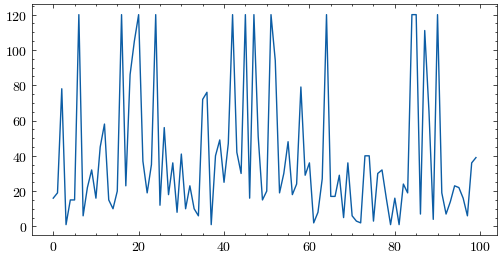

In [66]:
predict_cluster(df)